In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelBinarizer

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Flatten,Conv2D,Reshape
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

from sklearn.metrics import classification_report
import matplotlib.pyplot as plt 
from sklearn.metrics import roc_curve, auc

# Reading in pickle files

In [ ]:
X_train = pd.read_pickle('X_train.pkl')
X_test = pd.read_pickle('X_test.pkl')
y_train = pd.read_pickle('y_train.pkl')
y_test = pd.read_pickle('y_test.pkl')

In [5]:
#################################################################################
# Grouping by frame.time and unique ip.dst_host

# Concatenate X and y 
df_train = pd.concat([X_train, y_train], axis=1)
df_test = pd.concat([X_test, y_test], axis=1)

df_train['ip.dst_host'] = df_train['ip.dst_host'].astype('category')
df_test['ip.dst_host'] = df_test['ip.dst_host'].astype('category')

# Group categorical columns and boolean columns
categorical_cols = ['ip.src_host',
                    'tcp.dstport',
                    'tcp.srcport'] + df.select_dtypes(include=['boolean']).columns.tolist()

exclude = categorical_cols + ['Attack_type', 'frame.time','ip.dst_host']
# Group by each second, for numerical take the mean, for categorical take the mode
numerical_cols = [col for col in df_train.columns if col not in exclude]
aggregation_functions = {
        **{col: 'mean' for col in numerical_cols},  # Mean for numerical columns
        **{col: lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan for col in categorical_cols}  # Mode for categorical columns
    }

# Change attack_types to multi label vectors
def create_attack_vector(y_series):
    attack_vector = np.zeros(13, dtype=int)  
    # Drop NaN values from the series to avoid issues
    unique_labels = np.unique(y_series) 
    attack_vector[unique_labels] = 1  # Set indices in the vector to 1 for unique labels
    return attack_vector


CNN2D_X_train = df_train.groupby(['ip.dst_host', 'frame.time']).agg(aggregation_functions).reset_index()
CNN2D_X_test = df_test.groupby(['ip.dst_host', 'frame.time']).agg(aggregation_functions).reset_index()
CNN2D_y_train = df_train.groupby(['ip.dst_host', 'frame.time'])['Attack_type'].apply(create_attack_vector).reset_index()
CNN2D_y_test = df_test.groupby(['ip.dst_host', 'frame.time'])['Attack_type'].apply(create_attack_vector).reset_index()

#################################################################################
# Formatting y to unlist the multi label vector
CNN2D_y_train['Attack_type'] = CNN2D_y_train['Attack_type'].apply(lambda x: x if isinstance(x, np.ndarray) else np.zeros(13,dtype = int) )
unlist_y_train = pd.DataFrame(CNN2D_y_train['Attack_type'].tolist(), columns=[f'attack_{i}' for i in range(13)])
CNN2D_y_train = pd.concat([CNN2D_y_train,unlist_y_train],axis = 1)
CNN2D_y_train = CNN2D_y_train.drop(columns = ['Attack_type'])

CNN2D_y_test['Attack_type'] = CNN2D_y_test['Attack_type'].apply(lambda x: x if isinstance(x, np.ndarray) else np.zeros(13,dtype = int) )
unlist_y_test = pd.DataFrame(CNN2D_y_test['Attack_type'].tolist(), columns=[f'attack_{i}' for i in range(13)])
CNN2D_y_test = pd.concat([CNN2D_y_test,unlist_y_test],axis = 1)
CNN2D_y_test = CNN2D_y_test.drop(columns = ['Attack_type'])

#################################################################################
# Change dimensions to (time_intervals,ip.dst_host,num_samples)
pivoted_X_train = CNN2D_X_train.pivot(index='frame.time', columns='ip.dst_host').apply(lambda x: x.fillna(False) if x.dtype == 'boolean' else x.fillna(0))
pivoted_X_test = CNN2D_X_test.pivot(index='frame.time', columns='ip.dst_host').apply(lambda x: x.fillna(False) if x.dtype == 'boolean' else x.fillna(0))
pivoted_y_train = CNN2D_y_train.pivot(index='frame.time', columns='ip.dst_host')
pivoted_y_test = CNN2D_y_test.pivot(index='frame.time', columns='ip.dst_host')


X_train_tensor = pivoted_X_train.to_numpy().reshape(
    len(CNN2D_X_train['frame.time'].unique()),    
    len(CNN2D_X_train['ip.dst_host'].unique()),   
    -1)

X_test_tensor = pivoted_X_test.to_numpy().reshape(
    len(CNN2D_X_test['frame.time'].unique()),    
    len(CNN2D_X_test['ip.dst_host'].unique()),    
    -1)

y_train_tensor = pivoted_y_train.to_numpy().reshape(
    len(CNN2D_y_train['frame.time'].unique()),    
    len(CNN2D_y_train['ip.dst_host'].unique()),    
    -1)

y_test_tensor = pivoted_y_test.to_numpy().reshape(
    len(CNN2D_y_test['frame.time'].unique()),
    len(CNN2D_y_test['ip.dst_host'].unique()),    
    -1)

print(X_train_tensor.shape)
print(X_test_tensor.shape)
print(y_train_tensor.shape)
print(y_test_tensor.shape)

C:\Users\user\AppData\Local\Temp\ipykernel_16388\664735545.py:33: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  CNN2D_X_train = df_train.groupby(['ip.dst_host', 'frame.time']).agg(aggregation_functions).reset_index()
C:\Users\user\AppData\Local\Temp\ipykernel_16388\664735545.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  CNN2D_X_test = df_test.groupby(['ip.dst_host', 'frame.time']).agg(aggregation_functions).reset_index()
C:\Users\user\AppData\Local\Temp\ipykernel_16388\664735545.py:35: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. 

(41419, 17, 97)
(39125, 17, 97)
(41419, 17, 13)
(39125, 17, 13)


# Model

In [7]:
#################################################################################
# Model
X_train_tensor = X_train_tensor.astype(np.float32)
X_test_tensor = X_test_tensor.astype(np.float32)
y_train_tensor = y_train_tensor.astype(np.float32)
y_test_tensor = y_test_tensor.astype(np.float32)

input_shape = (X_train_tensor.shape[1],X_train_tensor.shape[2],1)
print(input_shape)

model = Sequential()
model.add(Conv2D(128, (7,7), input_shape=input_shape,activation='leaky_relu'))
model.add(Dropout(0.2))
model.add(Conv2D(64, (5, 5),activation='leaky_relu'))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(128,activation='leaky_relu'))
model.add(Dropout(0.2))
model.add(Dense(17 * 13, activation='sigmoid'))  # Output layer for multi-label classification
model.add(Reshape((17, 13)))

model.compile(optimizer= 'adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss',  
                               patience=5,          
                               restore_best_weights=True)  

reduce_lr = ReduceLROnPlateau(monitor='val_loss',    
                              factor=0.5,           
                              patience=3,           
                              min_lr=1e-6)  

CNN2D_hist = model.fit(X_train_tensor, y_train_tensor, validation_split=0.2, epochs=100, batch_size=500,callbacks=[early_stopping,reduce_lr])


(17, 97, 1)


c:\Users\user\Desktop\DSA4266 Project\.venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 101s 1s/step - accuracy: 0.1017 - loss: 0.2279 - val_accuracy: 0.0725 - val_loss: 0.0380 - learning_rate: 0.0010
Epoch 2/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 98s 1s/step - accuracy: 0.1016 - loss: 0.0105 - val_accuracy: 0.0813 - val_loss: 0.0285 - learning_rate: 0.0010
Epoch 3/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 98s 1s/step - accuracy: 0.1140 - loss: 0.0063 - val_accuracy: 0.0599 - val_loss: 0.0290 - learning_rate: 0.0010
Epoch 4/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 100s 1s/step - accuracy: 0.1170 - loss: 0.0046 - val_accuracy: 0.0479 - val_loss: 0.0278 - learning_rate: 0.0010
Epoch 5/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 99s 1s/step - accuracy: 0.1218 - loss: 0.0036 - val_accuracy: 0.0561 - val_loss: 0.0262 - learning_rate: 0.0010
Epoch 6/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 99s 1s/step - accuracy: 0.1264 - loss: 0.0032 - val_accuracy: 0.0678 - val_loss: 0.0270 - learning_rate: 0.0010
Epoch 7/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 101s 2s/step - accuracy: 0.1302 - loss: 0.0029 - val_

1223/1223 ━━━━━━━━━━━━━━━━━━━━ 26s 21ms/step
                       precision    recall  f1-score   support

             Backdoor       0.80      0.51      0.63      2887
            DDoS_HTTP       0.92      0.80      0.86      4377
            DDoS_ICMP       0.88      0.91      0.89      2084
             DDoS_TCP       0.87      0.78      0.82      1756
    OS_Fingerprinting       0.60      0.48      0.53       431
             Password       0.53      0.17      0.25      1852
        Port_Scanning       0.36      0.09      0.14      1407
           Ransomware       0.85      0.91      0.88     11636
        SQL_injection       0.92      0.93      0.92     11805
            Uploading       0.64      0.90      0.75       583
Vulnerability_scanner       0.00      0.00      0.00       164
                  XSS       0.84      0.95      0.89      3141
               Normal       0.98      1.00      0.99     23432

            micro avg       0.91      0.88      0.89     65555
        

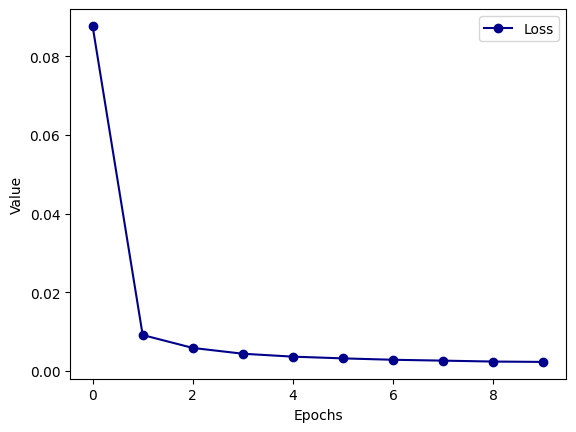

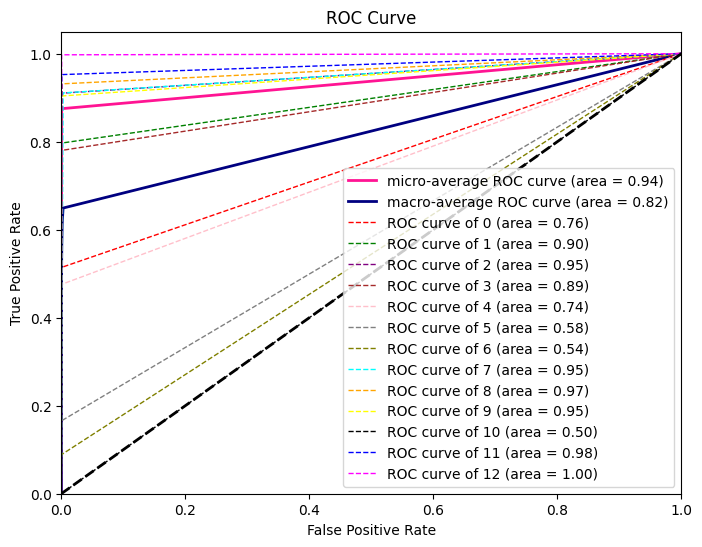

In [8]:
#################################################################################
# Evaluation
y_pred = model.predict(X_test_tensor)
y_pred_binary = (y_pred >= 0.5).astype(int) 

y_test_reshape = y_test_tensor.reshape(-1, 13)
y_pred_binary_reshape = y_pred_binary.reshape(-1, 13)

# 4. Generate classification report

target_names = ['Backdoor',
                'DDoS_HTTP',
                'DDoS_ICMP',
                'DDoS_TCP',
                'OS_Fingerprinting',
                'Password',
                'Port_Scanning',
                'Ransomware',
                'SQL_injection',
                'Uploading',
                'Vulnerability_scanner',
                'XSS',
                'Normal']
report = classification_report(y_test_reshape, y_pred_binary_reshape, target_names=target_names, zero_division=0)
print(report)

plt.plot(CNN2D_hist.history['loss'], label='Loss', marker='o', color='darkblue')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.show()

def plot_roc_curve(y_true, y_pred, n_classes):
    # Binarize the output
    lb = LabelBinarizer()
    y_true = lb.fit_transform(y_true)
    y_pred = lb.transform(y_pred)

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Compute macro-average ROC curve and ROC area
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure(figsize=(8, 6))
    plt.plot(fpr["micro"], tpr["micro"],
             label=f'micro-average ROC curve (area = {roc_auc["micro"]:0.2f})',
             color='deeppink', linewidth=2)

    plt.plot(fpr["macro"], tpr["macro"],
             label=f'macro-average ROC curve (area = {roc_auc["macro"]:0.2f})',
             color='navy', linewidth=2)

    colors = ['red', 'green', 'purple', 'brown', 'pink', 'gray', 'olive',
              'cyan', 'orange', 'yellow', 'black', 'blue', 'magenta']

    for i, color in zip(range(n_classes), colors):
        class_name = lb.classes_[i]
        plt.plot(fpr[i], tpr[i], color=color, lw=1,
                 label=f'ROC curve of {class_name} (area = {roc_auc[i]:0.2f})',
                 linestyle='--')


    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

plot_roc_curve(y_test_reshape, y_pred_binary_reshape, n_classes=len(np.unique(y_test)))